# Import & Download all the necessariy libraries

In [1]:
# Import Common Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import io
import re
from random import randint
import os

# install
!pip install git+https://github.com/huggingface/transformers
!pip install english-words

import tensorflow_datasets as tfds
from keras.preprocessing.sequence import pad_sequences
from transformers import TFBertForSequenceClassification, BertTokenizer, BertModel, BertConfig
from english_words import english_words_set

# Since the data size is big, we will need to use a GPU

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-qeeefzuq
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-qeeefzuq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 4.0 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 3.3 MB 70.1 MB/s 
     |████████████████████████████████| 596 kB 79.2 MB/s 
  Created wheel for transformers: filename=transformers-4.13.0.dev0-py3-none-any.whl size=3101338 sha256=3957afca7f3be0544f688cd881f27b200e07d09544bcc504f722daacc6c07bbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-7htduwkm/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully unin

# Data Cleaning

### Cleaning Process

In [2]:
# In our project, we have performed the data splitting, so we won't need to do the train_test_split anymore.

train = pd.read_csv("train_text_emoji_clean.csv")
test = pd.read_csv("test_text_emoji_clean.csv")
valid = pd.read_csv("valid_text_emoji_clean.csv")

# Remove usernames + punctuations + (numbers) + excessive spaces

for i in range(len(train)):
    message = train["tweets"][i]
    clean_message = message.split(":", 1)
    if len(clean_message) > 1:
        train["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[1])))
    else:
        train["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[0])))

for i in range(len(test)):
    message = test["tweets"][i]
    clean_message = message.split(":", 1)
    if len(clean_message) > 1:
        test["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[1])))
    else:
        test["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[0])))

    
for i in range(len(valid)):
    message = valid["tweets"][i]
    clean_message = message.split(":", 1)
    if len(clean_message) > 1:
        valid["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[1])))
    else:
        valid["tweets"][i] = re.sub(" +", " ", re.sub("\d+", " ", re.sub(r'[^\w\s]', '', clean_message[0])))

# Remove all rows that has more than 1 emoji representations

train = train[train['annotations'].map(len) == 1]
test = test[test['annotations'].map(len) == 1]
valid = valid[valid['annotations'].map(len) == 1]

# Reset the index after dropping several rows

train = train.reset_index()
test = test.reset_index()
valid = valid.reset_index()

# Assign the tweets as the dataset for the model

X_train = train["tweets"]
X_test = test["tweets"]
X_valid = valid["tweets"]

# Encode the emojis

train['classification'] = pd.factorize(train["annotations"])[0]
test['classification'] = pd.factorize(test["annotations"])[0]
valid['classification'] = pd.factorize(valid["annotations"])[0]

# Assign the encoded emojis as the labels for the model

y_train = train['classification']
y_test = test['classification']
y_valid = valid['classification']

### List of All Emojis

In [3]:
# Collect all the possible emojis (will be useful for our final prediction function)

emojis = train["annotations"].unique()
emojis

array(['😂', '😭', '😍', '🙄', '❤', '😊', '😩', '🤔', '😘', '🏽', '💯', '🙃'],
      dtype=object)

### Training Data

In [4]:
# Take a look at the training dataset + label

print(X_train)

print("==================================================")

print(y_train)

0                               school is so dead o my god
1        lol Ive been told mine is worse than yours but...
2        Im excited to hear them That shit is going rat...
3        Damn alycia knows everything even indirect tweets
4                               That sound like everything
                               ...                        
52881                 Or That Picture Was Just Cute To You
52882                    Im otw wit some gas still hate me
52883                                  Yeahhh you kinda do
52884                       nothing wit youuuuu raymundooo
52885    dont be that person who parks right next to me...
Name: tweets, Length: 52886, dtype: object
0         0
1         0
2         0
3         0
4         0
         ..
52881    11
52882    11
52883    11
52884    11
52885    11
Name: classification, Length: 52886, dtype: int64


### Test Data

In [5]:
# Take a look at the test dataset + label

print(X_test)

print("==================================================")

print(y_test)

0          The conversation is so deep i saw adele rolling
1         Lord were coo asf lol Just waiting for break ...
2                                                   I cant
3        These little kids talking about going to Canad...
4                                       only would do that
                               ...                        
13480                           The ball hates Croatia smh
13481                        Sexy bitch I hope she bout it
13482    I didnt realize that my tweets were private an...
13483                         lowkey annoyed for no reason
13484                          appreciate it while it last
Name: tweets, Length: 13485, dtype: object
0         0
1         0
2         0
3         0
4         0
         ..
13480    11
13481    11
13482    11
13483    11
13484    11
Name: classification, Length: 13485, dtype: int64


### Validation Data

In [6]:
# Take a look at the validation dataset + label

print(X_valid)

print("==================================================")

print(y_valid)

0                             hahahah you guys crack me up
1                                                  Im dead
2                     ate girl The tweet was before TMC pa
3        Also who wouldve thought that Will Griggs on f...
4                             Im not fooling w you tonight
                               ...                        
13476    Hopefully I dont fall asleep in the toilets in...
13477    Excited for the lake Not excited to wake up at...
13478    mom just told me shes leaving early to go to a...
13479          all these double shifts are killing my vibe
13480     I love when my legs are shaved but hate shavi...
Name: tweets, Length: 13481, dtype: object
0         0
1         0
2         0
3         0
4         0
         ..
13476    11
13477    11
13478    11
13479    11
13480    11
Name: classification, Length: 13481, dtype: int64


# Tokenization

### [CLS] & [SEP] Tokens Insertion

In [7]:
# In every BERT model, we need to include the tokens [CLS] & [SEP] for every row's text

# [SEP] token helps the model to understand the end of one input and the start of another input in the same sequence input.

# [CLS] is a special classification token and the last hidden state of BERT corresponding to this token (h[CLS]) is used for classification tasks.

sentences_train = ["[CLS] " + query + " [SEP]" for query in X_train]
sentences_test = ["[CLS] " + query + " [SEP]" for query in X_test]
sentences_valid = ["[CLS] " + query + " [SEP]" for query in X_valid]
print(sentences_train[0])
print(sentences_test[0])
print(sentences_valid[0])

[CLS] school is so dead o my god [SEP]
[CLS] The conversation is so deep i saw adele rolling [SEP]
[CLS] hahahah you guys crack me up [SEP]


### Tokenizing Each Sentences

In [8]:
# Tokenize all the sentences in the training, test, and validation datasets

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts_train = [tokenizer.tokenize(sent) for sent in sentences_train]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]
tokenized_texts_valid = [tokenizer.tokenize(sent) for sent in sentences_valid]
print ("Tokenize the first sentence of the training:")
print (tokenized_texts_train[0])


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence of the training:
['[CLS]', 'school', 'is', 'so', 'dead', 'o', 'my', 'god', '[SEP]']


# Text Padding

In [9]:
# Set the maximum sequence length. 
MAX_LEN = 50

# Pad our input tokens
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_valid = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_valid],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_train = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_train]
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids_valid = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_valid]
input_ids_valid = pad_sequences(input_ids_valid, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Finalize the data for the model

In [11]:
train_inputs = input_ids_train
test_inputs = input_ids_test
validation_inputs = input_ids_valid


train_labels = y_train
test_labels = y_test
validation_labels = y_valid

# Model Preparation

### Creating a New Model

In [19]:
# Setup the regularization (dropout rate) + number of classifications for the model
configuration = BertConfig(classification_dropout=0.15, hidden_dropout_prob =0.15, num_labels=12)

# Load model from pretrained model/vocabulary
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=configuration)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Optimizer + Loss Function + Metric

In [21]:
# Prepare training: 
# -. Compile tf.keras model with loss and learning rate schedule 
# -. Use AdamWeightDecay as the optimizer

from transformers import AdamWeightDecay

with tf.device('/device:GPU:0'):
  optimizer = AdamWeightDecay(learning_rate=3e-05, epsilon=1e-08, clipnorm=1.0)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

### Model Configuration

In [22]:
# Check the configuration of the model

configuration = model.config
configuration

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classification_dropout": 0.15,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.15,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  

### Model Summary

In [23]:
# Here's the summary of the model

model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  9228      
Total params: 109,491,468
Trainable params: 109,491,468
Non-trainable params: 0
_________________________________________________________________


# Model Training

### Training Part

In [24]:
import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(x=train_inputs, y=train_labels, validation_data = (validation_inputs, validation_labels), callbacks=[callback_1, callback_2], epochs = 40, batch_size=32)


Epoch 1/40
1653/1653 [==============================] - 427s 230ms/step - loss: 2.1094 - accuracy: 0.2636 - val_loss: 2.0195 - val_accuracy: 0.3038

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/40
1653/1653 [==============================] - 377s 228ms/step - loss: 1.8579 - accuracy: 0.3597 - val_loss: 2.0143 - val_accuracy: 0.3055

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/40
1653/1653 [==============================] - 376s 228ms/step - loss: 1.6294 - accuracy: 0.4365 - val_loss: 2.0342 - val_accuracy: 0.3256

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/40
1653/1653 [==============================] - 376s 228ms/step - loss: 1.3747 - accuracy: 0.5254 - val_loss: 2.2314 - val_accuracy: 0.3078

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/40
1653/1653 [==============================] - 376s 228ms/step - loss: 1.1302 - accuracy: 0.6120 - val_loss: 2.5131 - val_accuracy: 0.3001

Epoch 00005: saving model to training_1/cp.ckpt


### Visualization of the Model Training Result

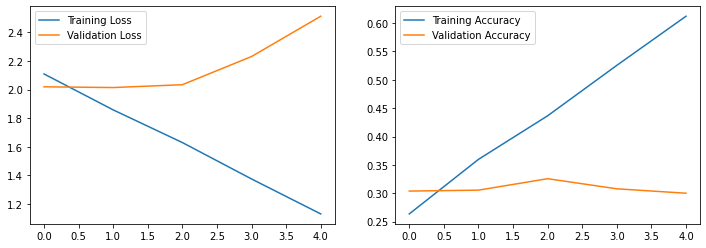

<Figure size 432x288 with 0 Axes>

In [25]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
  plt.subplot(1, 2, i + 1)
  plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
  plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
  plt.legend()
plt.show()
plt.savefig('bert_accuracy.png')

# Model Evaluation

### Loss + Accuracy

In [26]:
# Check out the accuracy + loss of the model using the test dataset

results = model.evaluate(test_inputs, test_labels, batch_size = 32)

print("test loss, test acc:", results)

422/422 [==============================] - 32s 75ms/step - loss: 2.5479 - accuracy: 0.2843
test loss, test acc: [2.5479001998901367, 0.28431591391563416]


In [27]:
very_complex_prediction = model.predict(test_inputs).logits

In [56]:
very_complex_prediction

array([[ 0.74225825,  3.3299634 , -2.8383467 , ..., -1.7460034 ,
        -2.3057902 ,  2.78811   ],
       [ 2.2871525 ,  3.2814837 , -2.5841162 , ..., -0.22682156,
        -2.001789  ,  1.6779553 ],
       [-0.14504553,  3.2306712 , -2.0154612 , ..., -0.305605  ,
        -1.1071423 ,  1.7576404 ],
       ...,
       [ 3.4192445 ,  0.0727715 , -2.3201282 , ..., -1.1395819 ,
        -2.3905714 ,  2.0825603 ],
       [ 1.171839  , -0.4045652 , -3.260077  , ...,  0.5668713 ,
         0.03051871,  2.6650698 ],
       [-2.13016   , -2.1930137 , -1.3604989 , ...,  4.5291877 ,
         5.6718006 , -0.46198732]], dtype=float32)

In [58]:
np.shape(very_complex_prediction)

(13485, 12)

### Predicted Labels

In [28]:
# Find out the predicted label for each row by finding the index of the maximum value for each row

prediction = []

for i in range(len(very_complex_prediction)):
  prediction.append(np.argmax(very_complex_prediction[i]))

print(prediction)

[6, 3, 6, 3, 11, 3, 3, 7, 9, 3, 1, 9, 3, 2, 9, 6, 3, 6, 8, 8, 0, 2, 11, 3, 10, 0, 2, 0, 0, 6, 7, 11, 11, 9, 0, 9, 1, 8, 3, 6, 0, 3, 0, 11, 0, 3, 11, 7, 3, 1, 0, 2, 6, 0, 5, 6, 5, 0, 7, 5, 0, 0, 0, 8, 11, 10, 11, 3, 9, 8, 0, 3, 6, 8, 9, 3, 3, 0, 11, 5, 1, 5, 3, 3, 0, 7, 7, 10, 6, 3, 2, 3, 7, 9, 9, 3, 8, 5, 0, 3, 8, 0, 7, 1, 0, 6, 10, 7, 0, 1, 2, 6, 0, 8, 1, 1, 0, 0, 6, 10, 3, 3, 11, 7, 0, 7, 0, 1, 6, 5, 9, 7, 5, 11, 5, 0, 7, 2, 0, 0, 3, 0, 11, 10, 3, 6, 10, 7, 7, 9, 0, 6, 0, 1, 2, 3, 0, 7, 3, 11, 2, 0, 1, 11, 7, 5, 2, 1, 8, 9, 1, 11, 3, 1, 0, 3, 3, 6, 4, 0, 3, 11, 5, 0, 1, 4, 9, 8, 2, 1, 3, 7, 2, 1, 9, 0, 5, 2, 0, 10, 3, 3, 5, 5, 2, 6, 3, 7, 9, 0, 1, 8, 8, 0, 8, 10, 0, 7, 1, 0, 3, 3, 6, 8, 6, 11, 5, 8, 2, 11, 11, 8, 5, 1, 11, 3, 1, 5, 5, 3, 0, 11, 6, 0, 0, 9, 0, 0, 11, 0, 2, 10, 3, 9, 11, 2, 4, 0, 1, 0, 6, 7, 2, 5, 0, 4, 7, 5, 0, 3, 0, 10, 3, 8, 10, 7, 0, 0, 0, 8, 1, 6, 9, 1, 6, 10, 1, 1, 3, 2, 10, 11, 2, 3, 0, 3, 9, 0, 3, 2, 2, 11, 7, 3, 5, 11, 1, 0, 10, 6, 0, 1, 1, 10, 2, 3, 2, 3, 5, 

In [29]:
test_labels = test_labels.values.tolist()

In [30]:
# Compare the actual and the predicted labels for each row of the test dataset

report = pd.DataFrame({'Actual': test_labels, 'Predicted': prediction})

report

,Actual,Predicted
0,0,6
1,0,3
2,0,6
3,0,3
4,0,11
...,...,...
13480,11,3
13481,11,10
13482,11,0
13483,11,3


In [31]:
# Accumulate the number of each [actual, prediction] pair

numbers = report.groupby(['Actual', 'Predicted']).size()

pair_values = pd.DataFrame(numbers)

In [32]:
pair_values

0
Actual Predicted     
0      0          366
       1          146
       2          121
       3          261
       4           51
...               ...
11     7           65
       8           21
       9           50
       10          32
       11         227

[144 rows x 1 columns]

In [33]:
data=[]

for i in range(12):
  row = []
  for j in range(12):
    row.append(pair_values[0][i][j])
  data.append(row)

data

[[366, 146, 121, 261, 51, 144, 125, 160, 67, 107, 117, 139],
 [195, 268, 116, 186, 80, 62, 265, 90, 65, 56, 44, 143],
 [60, 42, 431, 30, 110, 86, 66, 29, 118, 81, 11, 29],
 [117, 85, 31, 333, 15, 62, 177, 95, 29, 47, 65, 159],
 [18, 31, 78, 11, 245, 75, 17, 9, 171, 39, 22, 15],
 [29, 13, 66, 37, 73, 203, 29, 28, 137, 61, 30, 37],
 [82, 134, 94, 161, 36, 52, 392, 82, 31, 64, 49, 131],
 [97, 34, 48, 159, 18, 60, 84, 463, 14, 56, 70, 113],
 [25, 9, 32, 14, 54, 61, 5, 5, 250, 37, 10, 10],
 [113, 53, 120, 148, 112, 159, 102, 73, 124, 374, 225, 120],
 [46, 11, 16, 53, 36, 40, 22, 26, 29, 100, 282, 29],
 [61, 46, 29, 134, 22, 90, 103, 65, 21, 50, 32, 227]]

In [34]:
final = pd.DataFrame(data, index=emojis, columns=emojis)

final.index.name="Actual"

final.columns.name="Predicted"

### Confusion Matrix

In [35]:
final

Predicted,😂,😭,😍,🙄,❤,😊,😩,🤔,😘,🏽,💯,🙃
Actual,,,,,,,,,,,,
😂,366,146,121,261,51,144,125,160,67,107,117,139
😭,195,268,116,186,80,62,265,90,65,56,44,143
😍,60,42,431,30,110,86,66,29,118,81,11,29
🙄,117,85,31,333,15,62,177,95,29,47,65,159
❤,18,31,78,11,245,75,17,9,171,39,22,15
😊,29,13,66,37,73,203,29,28,137,61,30,37
😩,82,134,94,161,36,52,392,82,31,64,49,131
🤔,97,34,48,159,18,60,84,463,14,56,70,113
😘,25,9,32,14,54,61,5,5,250,37,10,10


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127997 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128580 missing from current font.
  fon

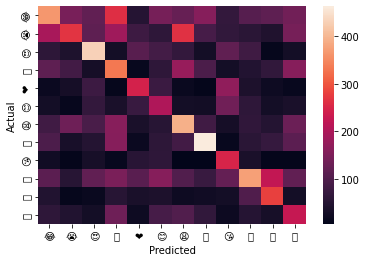

In [36]:
sns.heatmap(final)

### Summary of the Model Evaluation

In [37]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(test_labels, prediction)
cm

array([[366, 146, 121, 261,  51, 144, 125, 160,  67, 107, 117, 139],
       [195, 268, 116, 186,  80,  62, 265,  90,  65,  56,  44, 143],
       [ 60,  42, 431,  30, 110,  86,  66,  29, 118,  81,  11,  29],
       [117,  85,  31, 333,  15,  62, 177,  95,  29,  47,  65, 159],
       [ 18,  31,  78,  11, 245,  75,  17,   9, 171,  39,  22,  15],
       [ 29,  13,  66,  37,  73, 203,  29,  28, 137,  61,  30,  37],
       [ 82, 134,  94, 161,  36,  52, 392,  82,  31,  64,  49, 131],
       [ 97,  34,  48, 159,  18,  60,  84, 463,  14,  56,  70, 113],
       [ 25,   9,  32,  14,  54,  61,   5,   5, 250,  37,  10,  10],
       [113,  53, 120, 148, 112, 159, 102,  73, 124, 374, 225, 120],
       [ 46,  11,  16,  53,  36,  40,  22,  26,  29, 100, 282,  29],
       [ 61,  46,  29, 134,  22,  90, 103,  65,  21,  50,  32, 227]])

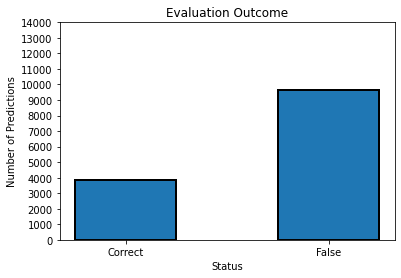

In [40]:
correct = 0

for i in range(12):
  correct += cm[i][i]

total = 0

for i in range(12):
  for j in range(12):
    total += cm[i][j]

wrong = total - correct

plt.title("Evaluation Outcome")

# Data
status = ['Correct', 'False']
num   = [correct, wrong]

# Plot
plt.bar(status, num, width=0.50, edgecolor='k', linewidth=2)

plt.xlabel("Status")
plt.ylabel("Number of Predictions")

# Create the graph ticks with a list comprehension
plt.yticks(ticks=[x * 1000 for x in range(15)])

# Render
plt.savefig("plot.png")
plt.show()

In [51]:
print("Correct: "+str(correct))
print("False: "+str(wrong))

print("Test Accuracy: "+str(correct/total))

Correct: 3834
False: 9651
Test Accuracy: 0.2843159065628476


# Function for Emoji Prediction

In [54]:
# Before predicting the emoji from a text, don't forget to do the following:
#   -. Include the [CLS] & [SEP] tokens
#   -. Tokenize the sentence
#   -. Pad the tokenized sentence with a fixed padding length
#   -. Find the index of the highest value from the prediction result
#   -. return the emoji with the index

def prediction(text):
  semi_processed_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(semi_processed_text)
  tokenized_text_in_array = [tokenized_text]
  text_with_padding = pad_sequences([tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text_in_array], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  index = np.argmax(model.predict(text_with_padding).logits[0])
  return emojis[index]

In [64]:
emojis

array(['😂', '😭', '😍', '🙄', '❤', '😊', '😩', '🤔', '😘', '🏽', '💯', '🙃'],
      dtype=object)

In [55]:
prediction("Hi, it's really nice to meet you")

'😊'

In [60]:
prediction("Why do I have to fail a lot??")

'🙃'

In [63]:
prediction("I love you so much, babe!")

'❤'